In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import unicodedata
import sys
import string

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer, pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords

from sklearn.svm import OneClassSVM 
from sklearn.metrics import log_loss, make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


**EDA**

In [2]:
#makeup alley
ma = pd.read_csv('makeup_alley_data.csv')

In [3]:
#2 sephora datasets
s1 = pd.read_csv('Sephora_review.csv')
s2 = pd.read_csv('sephora_review_ordinary.csv')

In [4]:
s1 = s1[['review_text', 'rating']]

In [5]:
s1

,review_text,rating
0,"Sometimes I stray from this cleanser, but I al...",5
1,I am a 41 year old African American woman with...,5
2,I'm really enjoying this product. Received a s...,5
3,"I tried this cleanser at a friends house, and ...",3
4,leaves the skin feeling fresh and revived... j...,5
...,...,...
995,"Only have to use a pea size amount, foams and ...",5
996,This is by far the best cleansing foam I have ...,5
997,I have a very hard time finding facial cleaner...,5
998,I got a sample from sephora this product is a ...,1


In [6]:
s2 = s2[['r_review', 'r_star']]
s2 = s2.rename(columns={'r_review': 'review_text', 'r_star':'rating'})

In [7]:
#combine 2 dataset
s = pd.concat([s1,s2])

In [8]:
s = s.rename(columns={'review_text':'Review','rating':'Rating'})

In [9]:
s.head()

,Review,Rating
0,"Sometimes I stray from this cleanser, but I al...",5
1,I am a 41 year old African American woman with...,5
2,I'm really enjoying this product. Received a s...,5
3,"I tried this cleanser at a friends house, and ...",3
4,leaves the skin feeling fresh and revived... j...,5


In [10]:
ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227370 entries, 0 to 227369
Data columns (total 5 columns):
Product    227370 non-null object
Brand      214570 non-null object
Review     227370 non-null object
Rating     227370 non-null float64
User       227365 non-null object
dtypes: float64(1), object(4)
memory usage: 8.7+ MB


In [63]:
ma.describe()

,Rating
count,227370.000000
mean,3.695188
std,1.408161
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [11]:
#s.to_csv('Sephora_data.csv')

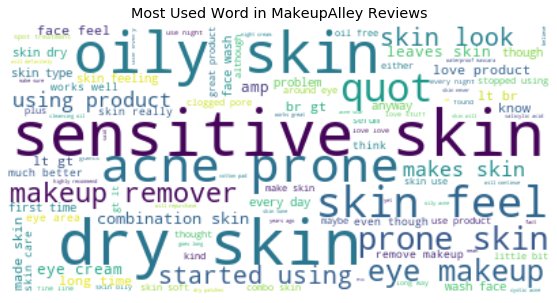

In [12]:
#review text not cleaned
text = " ".join(review for review in ma.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in MakeupAlley Reviews')
plt.axis("off")
plt.show()

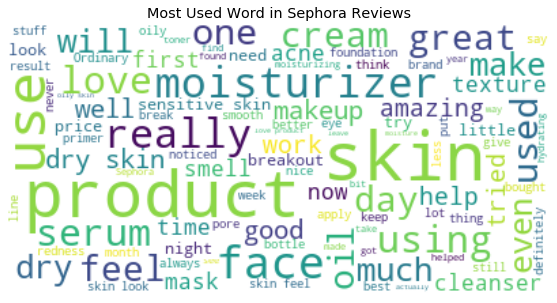

In [13]:
#review text not cleaned
text = " ".join(review for review in s.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in Sephora Reviews')
plt.axis("off")
plt.show()

In [14]:
s.Review.iloc[1]

'I am a 41 year old African American woman with sign of hormonal aging. This product has my skin looking great, but you must use all of the other products for the full benefits.'

In [15]:
s_review_len = [len(s.Review.iloc[i]) for i in range(len(s))]

In [65]:
np.mean(s_review_len)

335.95563603440473

In [16]:
ma_review_len = [len(ma.Review.iloc[i]) for i in range(len(ma))]

In [64]:
np.mean(ma_review_len)

593.4892949817478

([<matplotlib.axis.XTick at 0x11f929668>,
 <a list of 2 Text xticklabel objects>)

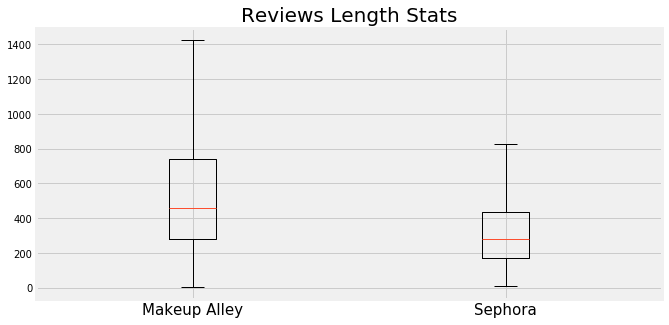

In [34]:
plt.figure(figsize=(10,5))
plt.boxplot([ma_review_len, s_review_len], showfliers = False)
plt.title('Reviews Length Stats', fontsize = 20)
plt.xticks((1,2), ('Makeup Alley','Sephora'), fontsize=15)

(0, 3000)

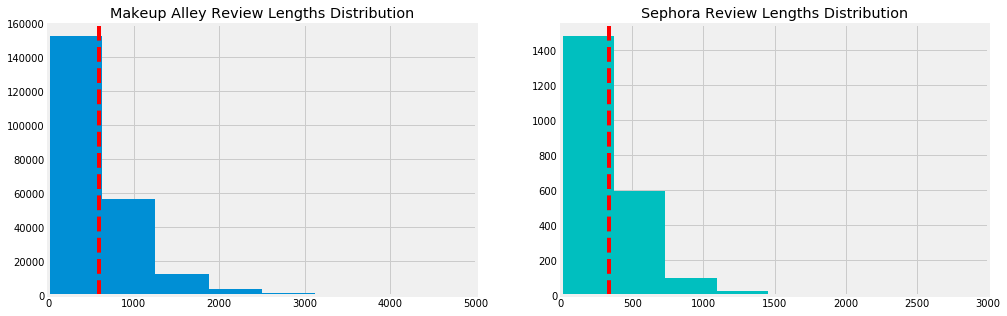

In [101]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
# plt.title('Review Lengths Distribution')
axs[0].hist(ma_review_len)
axs[0].axvline(np.mean(ma_review_len), color ='r', linestyle='--')
axs[0].set_title('Makeup Alley Review Lengths Distribution')
axs[0].set_xlim(0,5000)

axs[1].hist(s_review_len, color = 'c')
axs[1].axvline(np.mean(s_review_len), color ='r', linestyle='--')
axs[1].set_title('Sephora Review Lengths Distribution')
axs[1].set_xlim(0,3000)


In [118]:
ma.Rating.value_counts()

5.0    93411
4.0    51442
3.0    30045
1.0    27727
2.0    24745
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Sephora Rating Distribution')

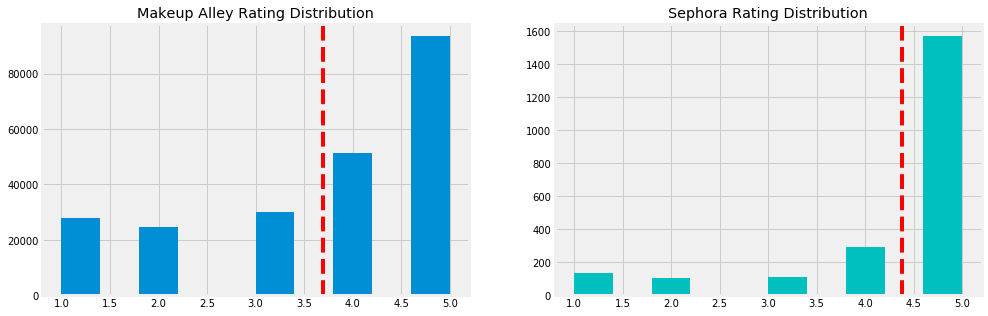

In [125]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(ma.Rating)
axs[0].axvline(np.mean(ma.Rating), color ='r' , linestyle='--')
axs[0].set_title('Makeup Alley Rating Distribution')

axs[1].hist(s.Rating, color ='c')
axs[1].axvline(np.mean(s.Rating), color ='r', linestyle='--'
              )
axs[1].set_title('Sephora Rating Distribution')

**Clean Text**

In [126]:
import unicodedata
import sys
def cleanText(wordSeries):
        tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
        def remove_accents(input_str):
            nfkd_form = unicodedata.normalize('NFKD', input_str)
            only_ascii = nfkd_form.encode('ASCII', 'ignore')
            return only_ascii.decode()
        def remove_punctuation(text):
            return text.translate(tbl)
        wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))#remove punctuation
        wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))#remove digits
        wordSeries = wordSeries.apply(lambda x: x.lower())#lower cases
        wordSeries = wordSeries.apply(lambda x: x.replace('<br >', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('<br>', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('\n', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('\n\n', ' '))
        wordSeries = wordSeries.apply(lambda x: x.replace('$', ' '))
        wordSeries = wordSeries.apply(lambda x: x.replace('>', ' '))
        wordSeries = wordSeries.apply(lambda x: remove_accents(x))
        wordSeries = wordSeries.apply(lambda x: x.replace('`', ''))#remove extra punctuation
        # wordSeries = wordSeries.apply(lambda x: x.replace(' id ', ' '))
        return wordSeries
    
#example df name test, column name text --> cleanText(test.text)

In [127]:
ma.Review = cleanText(ma.Review)

In [128]:
s.Review = cleanText(s.Review)

In [168]:
ma2 = ma[['Review']]

In [169]:
s2 = s[['Review']]

**Bag of Word**

In [170]:
s2['Review'] = s2['Review'].apply(word_tokenize)
ma2['Review'] = ma2['Review'].apply(word_tokenize)

/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
#remove stopwords
stopwords_ = set(stopwords.words('english'))
s2['Review'] = s2['Review'].apply(lambda x: [item for item in x if item not in stopwords_ ])
ma2['Review'] = ma2['Review'].apply(lambda x: [item for item in x if item not in stopwords_ ])

/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [172]:
#using snowball to preserve some words ex: 'better' (so it does not become 'good')
stemmer = SnowballStemmer("english")
s2['Review'] = s2['Review'].apply(lambda x: [stemmer.stem(y) for y in x])
ma2['Review'] = ma2['Review'].apply(lambda x: [stemmer.stem(y) for y in x])

/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [177]:
#Detokenized
s2['Detokenized'] = s2['Review'].apply(lambda x:' '.join([y for y in x ]))
ma2['Detoknized'] = ma2['Review'].apply(lambda x:' '.join([y for y in x ]))

/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/suchaya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


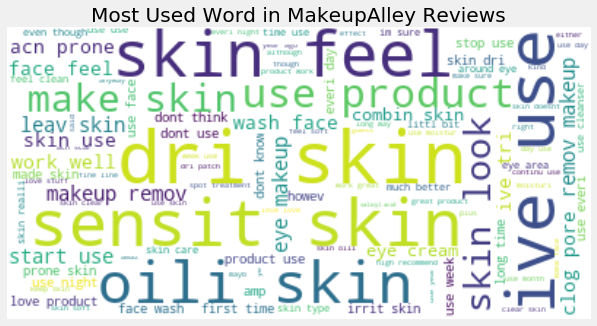

In [185]:
#review text cleaned
text = " ".join(review for review in ma2.Detoknized)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in MakeupAlley Reviews')
plt.axis("off")
plt.show()

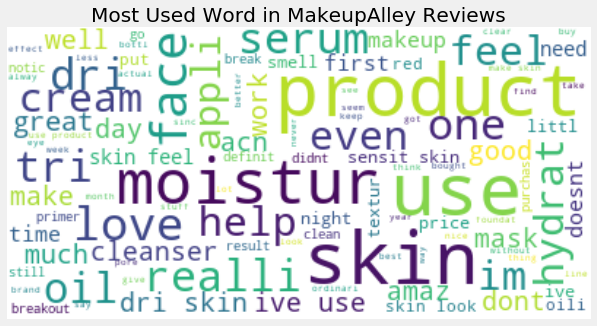

In [186]:
#review text cleaned
text = " ".join(review for review in s2.Detokenized)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in MakeupAlley Reviews')
plt.axis("off")
plt.show()

**Vectorizing**

In [149]:
def vectorize(X, max_features, ngram_range=None):
    '''
    X: Detokenized Column
    max_features: maximum features wanted
    ngram_range: do I want n-gram?
    '''
    tfidf = TfidfVectorizer(max_features= 300)
    doc_tfidf_matrix = tfidf.fit_transform(true['Detokenized']).todense()
    vector = pd.DataFrame(doc_tfidf_matrix, columns = tfidf.get_feature_names())
    return vector

**One Class Classification Model**

In [41]:
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y)

In [39]:
#GridSearch
def BestEstimator(X_train, X_test, y_train, y_test):
    model = OneClassSVM()

    #default Kernel is 'rbf'

    gammas = np.arange(0,1,0.001)
    nus = np.arange(0,1.1,0.1)
    shrinkings = [True, False]
    parameters = {'gamma': gammas,
                  'nu': nus,
                  'shrinkings': shrinkings}

    scorer = make_scorer(log_loss,
                         greater_is_better=False,
                         needs_proba=True)

    clf = GridSearchCV(model,
                       parameters,
                       cv=10,
                       scoring=scorer)

    clf.fit(X_train, y_train)

    print(f"log loss = {-clf.score(X_test, y_test)}") 
    print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")
    print(clf.best_estimator_)
    print(clf.best_params_)
    print(clf.best_score_ )
    return clf.best_estimator_

In [42]:
#use parameters got from gridsearch to run a model
def confusion_matrix(BestEstimator, X_test, y_test):
    model = BestEstimator
    y_pred = model.fit.predict(X_test)
    return confusion_matrix(y_test, y_pred) 